# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Project_data.zip','r') as zip:
   zip.extractall()

In [5]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes
print ('# num_classes =', num_classes)

# num_classes = 5


In [6]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(
<ipython-input-7-ce754b7b83e1>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread("/content/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
<ipython-input-7-ce754b7b83e1>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread("/content/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe

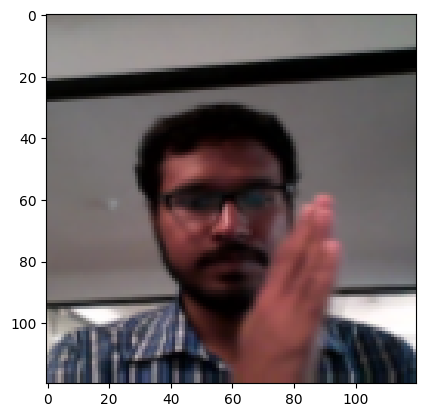

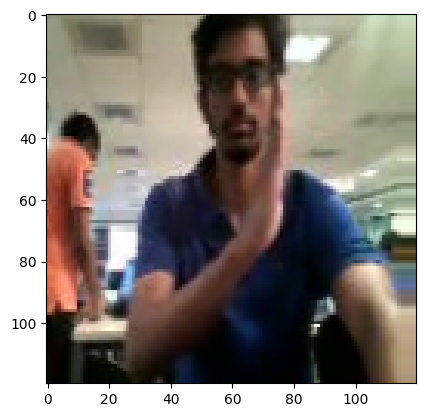

In [7]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/content/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imageio.imread("/content/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape
#and the conv3D will throw error if the inputs in a batch have different shapes
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)
plt.imshow(image2)
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

1. Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120) and dropout = 0.20

In [11]:
height = 120
width = 120
num_images = 20
epochs = 25
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', epochs)
print('# batch_size= ', batch_size)

# height=  120
# width=  120
# num_images=  20
# epochs=  25
# batch_size=  10


In [12]:


model = Sequential()

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(num_classes))
model.add(Activation('softmax'))



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 20, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 60, 60, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
num_epochs = 25
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-21-5ccf9040a95b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
66/67 [============================>.] - ETA: 1s - loss: 1.5098 - categorical_accuracy: 0.4348

<ipython-input-10-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5152 - categorical_accuracy: 0.4344
Epoch 1: saving model to model_init_2024-01-2506_12_00.114964/model-00001-1.51521-0.43439-2.43836-0.21000.h5
67/67 [==============================] - 144s 2s/step - loss: 1.5152 - categorical_accuracy: 0.4344 - val_loss: 2.4384 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.2195 - categorical_accuracy: 0.5189
Epoch 2: saving model to model_init_2024-01-2506_12_00.114964/model-00002-1.21947-0.51885-2.65672-0.24000.h5
67/67 [==============================] - 129s 2s/step - loss: 1.2195 - categorical_accuracy: 0.5189 - val_loss: 2.6567 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0233 - categorical_accuracy: 0.6244
Epoch 3: saving model to model_init_2024-01-2506_12_00.114964/model-00003-1.02330-0.62443-5.85955-0.15000.h5
67/67 [==============================] - 144s 2s/step - loss: 1.0233 - categorical_accuracy: 0.6244 - val_loss: 5.8596 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 4/25
67/67 [==============================] - ETA: 0s - loss: 0.9592 - categorical_accuracy: 0.6425
Epoch 4: saving model to model_init_2024-01-2506_12_00.114964/model-00004-0.95920-0.64253-3.68953-0.25000.h5

Epoch 4: ReduceLROnPlateau redu

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


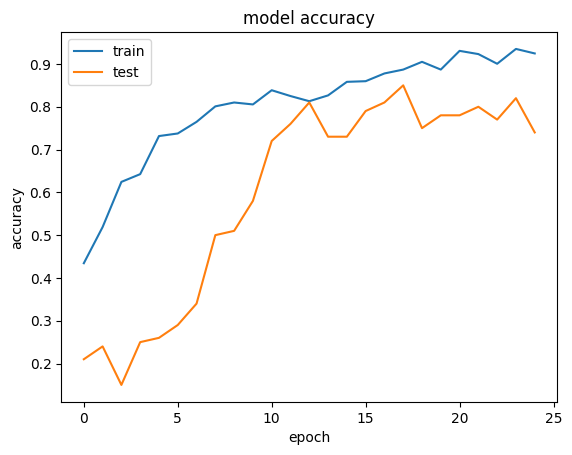

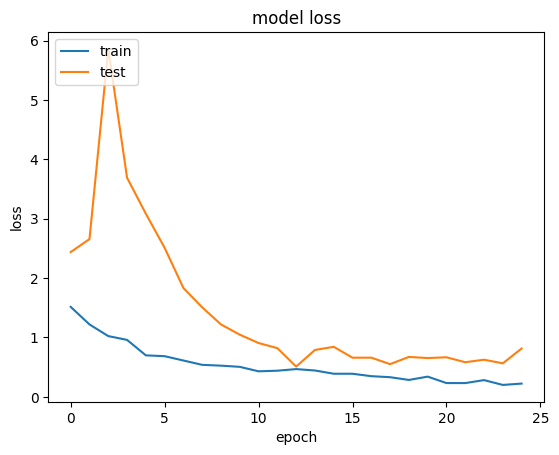

In [22]:
plot_loss_accuracy(history)

2. Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [26]:
height = 160
width = 160
num_images = 20
num_epochs = 20
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', num_epochs)
print('# batch_size= ', batch_size)

# height=  160
# width=  160
# num_images=  20
# epochs=  20
# batch_size=  10


In [31]:
train_generator = generator(train_path, train_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)

In [32]:
model = Sequential()

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_14 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 10, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)   

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [33]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-33-3f8737701920>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 4s - loss: 1.5867 - categorical_accuracy: 0.4246

<ipython-input-10-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5986 - categorical_accuracy: 0.4238
Epoch 1: saving model to model_init_2024-01-2506_12_00.114964/model-00001-1.59862-0.42383-5.68523-0.16000.h5
67/67 [==============================] - 244s 3s/step - loss: 1.5986 - categorical_accuracy: 0.4238 - val_loss: 5.6852 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.1271 - categorical_accuracy: 0.5686
Epoch 2: saving model to model_init_2024-01-2506_12_00.114964/model-00002-1.12711-0.56863-8.41394-0.16000.h5
67/67 [==============================] - 189s 3s/step - loss: 1.1271 - categorical_accuracy: 0.5686 - val_loss: 8.4139 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8639 - categorical_accuracy: 0.6757
Epoch 3: saving model to model_init_2024-01-2506_12_00.114964/model-00003-0.86394-0.67572-5.87254-0.30000.h5
67/67 [==============================] - 204s 3s/step - loss: 0.8639 - categorical_accuracy: 0.6757 - val_loss: 5.8725 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 4/20
67/67 [==============================] - ETA: 0s - loss: 0.7022 - categorical_accuracy: 0.7315
Epoch 4: saving model to model_init_2024-01-2506_12_00.114964/model-00004-0.70224-0.73152-4.99424-0.23000.h5
67/67 [=========================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


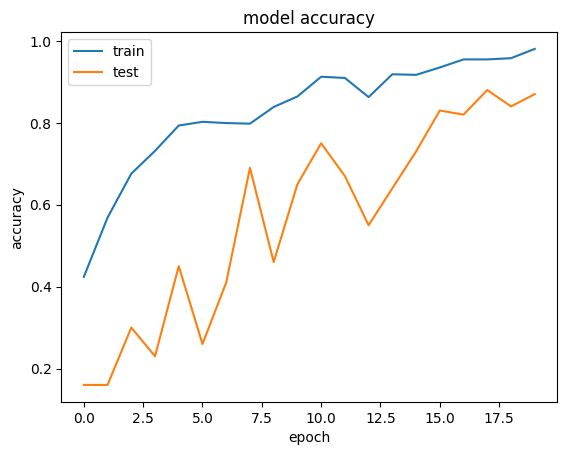

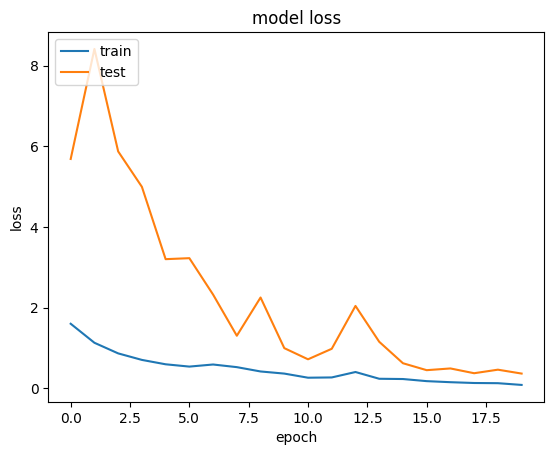

In [34]:
plot_loss_accuracy(history)

3. Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set for 120x120 image

In [35]:
height = 120
width = 120
num_images = 20
num_epochs = 20
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', num_epochs)
print('# batch_size= ', batch_size)

train_generator = generator(train_path, train_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width,augment=True)
val_generator = generator(val_path, val_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)

# height=  120
# width=  120
# num_images=  20
# epochs=  20
# batch_size=  10


In [36]:
model = Sequential()

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_21 (Activation)  (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 20, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 10, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 32)   

In [37]:
model_name = 'model_init_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-37-a04221835c54>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
66/67 [============================>.] - ETA: 1s - loss: 1.6237 - categorical_accuracy: 0.4409

<ipython-input-10-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6245 - categorical_accuracy: 0.4404
Epoch 1: saving model to model_init_3_2024-01-2506_12_00.114964/model-00001-1.62449-0.44042-2.95348-0.16000.h5
67/67 [==============================] - 160s 2s/step - loss: 1.6245 - categorical_accuracy: 0.4404 - val_loss: 2.9535 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.3163 - categorical_accuracy: 0.4811
Epoch 2: saving model to model_init_3_2024-01-2506_12_00.114964/model-00002-1.31633-0.48115-3.07671-0.26000.h5
67/67 [==============================] - 150s 2s/step - loss: 1.3163 - categorical_accuracy: 0.4811 - val_loss: 3.0767 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0496 - categorical_accuracy: 0.5732
Epoch 3: saving model to model_init_3_2024-01-2506_12_00.114964/model-00003-1.04963-0.57315-3.56354-0.26000.h5
67/67 [==============================] - 147s 2s/step - loss: 1.0496 - categorical_accuracy: 0.5732 - val_loss: 3.5635 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 4/20
67/67 [==============================] - ETA: 0s - loss: 0.9565 - categorical_accuracy: 0.6320
Epoch 4: saving model to model_init_3_2024-01-2506_12_00.114964/model-00004-0.95654-0.63198-2.96261-0.30000.h5

Epoch 4: ReduceLROnPlatea

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


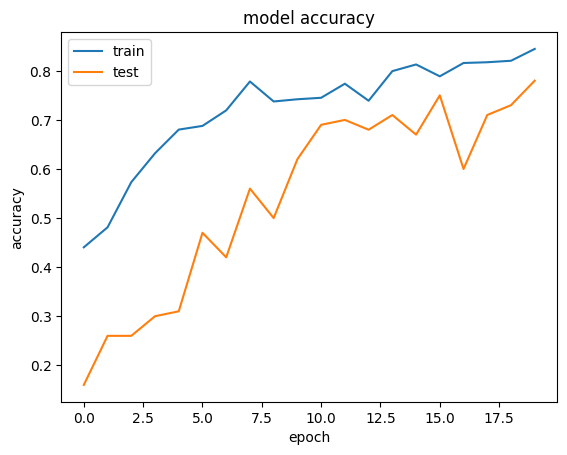

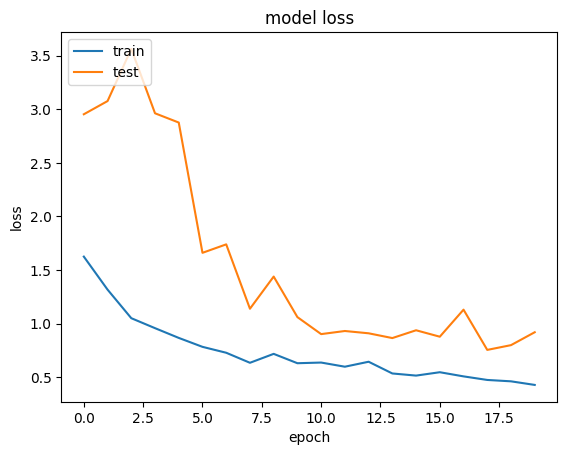

In [38]:
plot_loss_accuracy(history)

4. Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [39]:
height = 120
width = 120
num_images = 20
num_epochs = 25
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', num_epochs)
print('# batch_size= ', batch_size)

train_generator = generator(train_path, train_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)

# height=  120
# width=  120
# num_images=  20
# epochs=  25
# batch_size=  10


In [40]:
model = Sequential()

model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 32   2624      
                             )                                   
                                                                 
 activation_28 (Activation)  (None, 20, 120, 120, 32   0         
                             )                                   
                                                                 
 batch_normalization_24 (Ba  (None, 20, 120, 120, 32   128       
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_16 (MaxPooli  (None, 10, 60, 60, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 60, 60, 64)   

In [41]:
model_name = 'model_init_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-41-a92cc39232ba>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
66/67 [============================>.] - ETA: 1s - loss: 1.7020 - categorical_accuracy: 0.3848

<ipython-input-10-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6993 - categorical_accuracy: 0.3846
Epoch 1: saving model to model_init_4_2024-01-2506_12_00.114964/model-00001-1.69929-0.38462-1.80720-0.39000.h5
67/67 [==============================] - 149s 2s/step - loss: 1.6993 - categorical_accuracy: 0.3846 - val_loss: 1.8072 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.3431 - categorical_accuracy: 0.4555
Epoch 2: saving model to model_init_4_2024-01-2506_12_00.114964/model-00002-1.34313-0.45551-2.33351-0.23000.h5
67/67 [==============================] - 129s 2s/step - loss: 1.3431 - categorical_accuracy: 0.4555 - val_loss: 2.3335 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.1878 - categorical_accuracy: 0.5415
Epoch 3: saving model to model_init_4_2024-01-2506_12_00.114964/model-00003-1.18780-0.54148-3.13518-0.22000.h5
67/67 [===================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


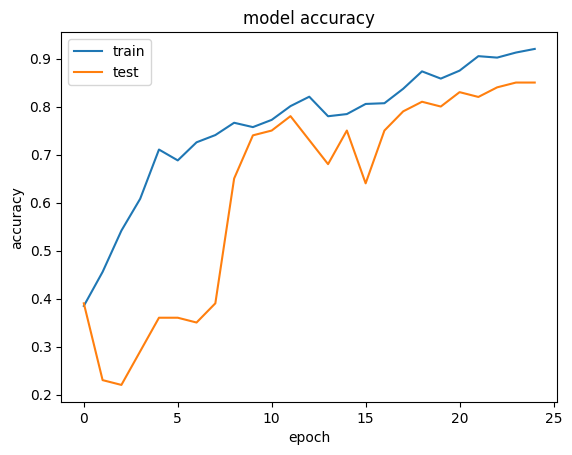

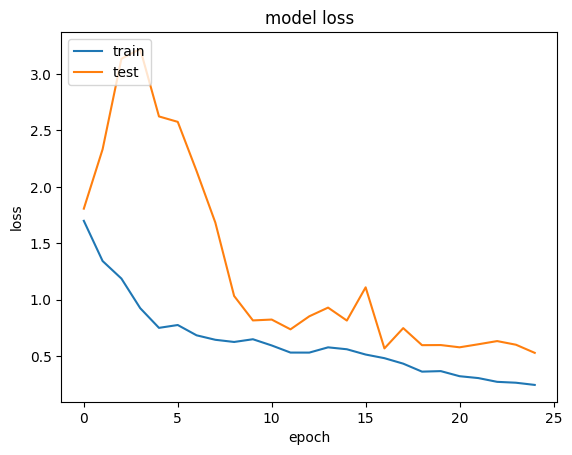

In [42]:
plot_loss_accuracy(history)

5.TRANSFER LEARNING - MobileNet Conv2d + GRU

Mobilenet (retrain all weights)
+ GRU (128 cells)
+ Dense (128 nodes)
+ image size 120 by 120
+ 20 images per video


In [17]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

17225924/17225924 [==============================] - 1s 0us/step
Number of layers in the pretrained mobilenet model:  86


In [50]:
height = 120
width = 120
num_images = 20
num_epochs = 20
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', num_epochs)
print('# batch_size= ', batch_size)

train_generator = generator(train_path, train_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)

# height=  120
# width=  120
# num_images=  20
# epochs=  25
# batch_size=  10


In [51]:
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))

#model.add(LSTM(128))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(num_classes, activation='softmax'))


In [52]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 20, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [53]:
model_name = 'model_init_mobile+GRU_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-53-4fdaf6fe93ff>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
65/67 [============================>.] - ETA: 3s - loss: 1.0735 - categorical_accuracy: 0.5538

<ipython-input-10-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.0628 - categorical_accuracy: 0.5611
Epoch 1: saving model to model_init_mobile+GRU_1_2024-01-2506_12_00.114964/model-00001-1.06282-0.56109-0.73595-0.72000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 163s 2s/step - loss: 1.0628 - categorical_accuracy: 0.5611 - val_loss: 0.7359 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.4805 - categorical_accuracy: 0.8492
Epoch 2: saving model to model_init_mobile+GRU_1_2024-01-2506_12_00.114964/model-00002-0.48052-0.84917-0.38952-0.83000.h5
67/67 [==============================] - 131s 2s/step - loss: 0.4805 - categorical_accuracy: 0.8492 - val_loss: 0.3895 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.4160 - categorical_accuracy: 0.8537
Epoch 3: saving model to model_init_mobile+GRU_1_2024-01-2506_12_00.114964/model-00003-0.41599-0.85370-0.56988-0.82000.h5
67/67 [==============================] - 149s 2s/step - loss: 0.4160 - categorical_accuracy: 0.8537 - val_loss: 0.5699 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 4/25
67/67 [=========================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


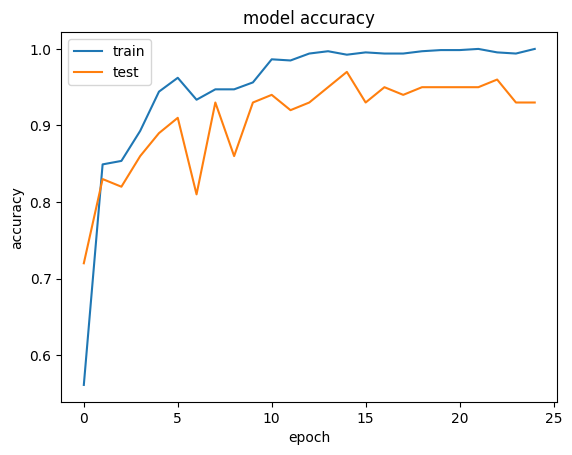

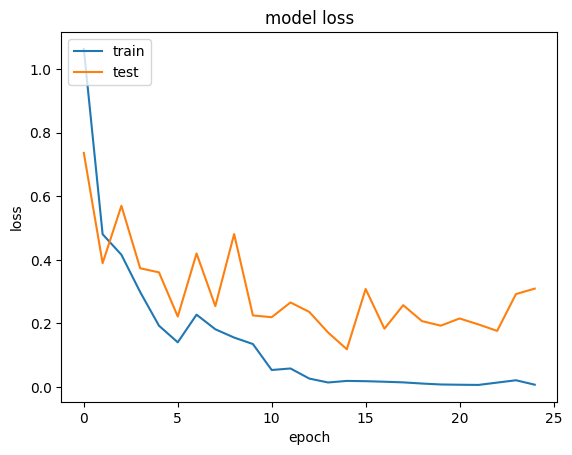

In [54]:
plot_loss_accuracy(history)

6. Mobilenet (retrain all weights)
+ GRU (128 cells)
+ Dense (128 nodes)
+ Dense (128 nodes)
+ image size 120 by 120
+ 20 images per video
+ random transformation


In [14]:
height = 120
width = 120
num_images = 20
num_epochs = 20
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', num_epochs)
print('# batch_size= ', batch_size)

train_generator = generator(train_path, train_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width,augment=True)
val_generator = generator(val_path, val_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)

# height=  120
# width=  120
# num_images=  20
# epochs=  20
# batch_size=  10


In [16]:
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))

#model.add(LSTM(128))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)              

In [20]:
model_name = 'model_init_mobile+GRU_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-20-0ac422caa0af>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-8-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 3s - loss: 1.1414 - categorical_accuracy: 0.5123

<ipython-input-8-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.1375 - categorical_accuracy: 0.5128
Epoch 1: saving model to model_init_mobile+GRU_2_2024-01-2611_46_22.769877/model-00001-1.13752-0.51282-0.56075-0.79000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 177s 2s/step - loss: 1.1375 - categorical_accuracy: 0.5128 - val_loss: 0.5608 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5537 - categorical_accuracy: 0.7903
Epoch 2: saving model to model_init_mobile+GRU_2_2024-01-2611_46_22.769877/model-00002-0.55372-0.79035-0.48310-0.81000.h5
67/67 [==============================] - 147s 2s/step - loss: 0.5537 - categorical_accuracy: 0.7903 - val_loss: 0.4831 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3948 - categorical_accuracy: 0.8612
Epoch 3: saving model to model_init_mobile+GRU_2_2024-01-2611_46_22.769877/model-00003-0.39478-0.86124-0.78847-0.78000.h5
67/67 [==============================] - 145s 2s/step - loss: 0.3948 - categorical_accuracy: 0.8612 - val_loss: 0.7885 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 4/20
67/67 [=========================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


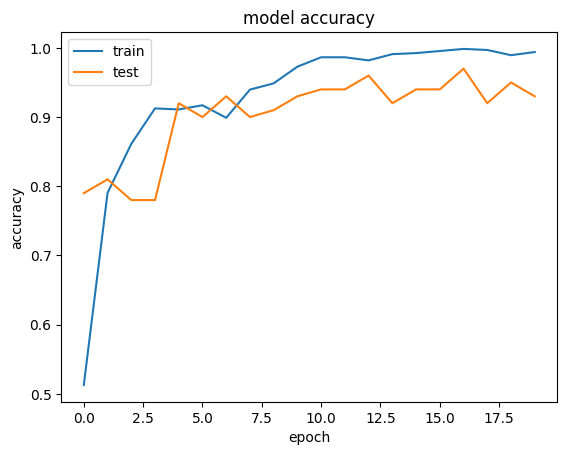

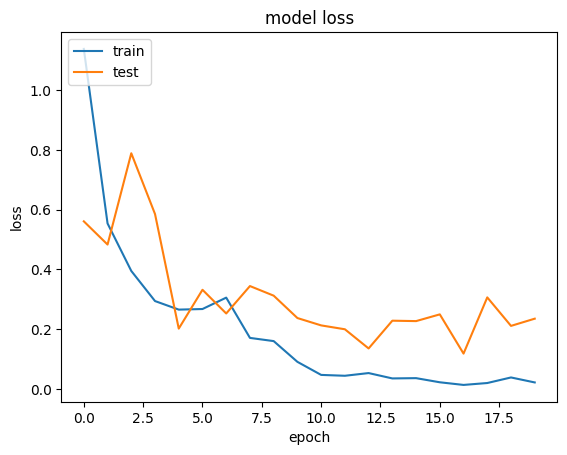

In [21]:
plot_loss_accuracy(history)

In [ ]:
# Fine tuning can be done using below:

# # Fine-tune after this layer
# fine_tune_at = 40

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in mobilenet_transfer.layers[:fine_tune_at]:
#   layer.trainable = False

7.Mobilenet (retrain all weights)
+ LSTM (128 cells)
+ Dense (128 nodes)
+ image size 120 by 120
+ 20 images per video



In [15]:
height = 120
width = 120
num_images = 20
num_epochs = 20
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', num_epochs)
print('# batch_size= ', batch_size)

train_generator = generator(train_path, train_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)
val_generator = generator(val_path, val_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)

# height=  120
# width=  120
# num_images=  20
# epochs=  20
# batch_size=  10


In [18]:
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)              

In [19]:
model_name = 'model_init_mobile+LSTM_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-19-c2dd05a44e65>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-8-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 3s - loss: 1.2394 - categorical_accuracy: 0.4954

<ipython-input-8-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2307 - categorical_accuracy: 0.4992
Epoch 1: saving model to model_init_mobile+LSTM_1_2024-01-2811_34_35.642900/model-00001-1.23071-0.49925-0.89064-0.64000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 208s 3s/step - loss: 1.2307 - categorical_accuracy: 0.4992 - val_loss: 0.8906 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7197 - categorical_accuracy: 0.7360
Epoch 2: saving model to model_init_mobile+LSTM_1_2024-01-2811_34_35.642900/model-00002-0.71975-0.73605-0.56368-0.79000.h5
67/67 [==============================] - 164s 2s/step - loss: 0.7197 - categorical_accuracy: 0.7360 - val_loss: 0.5637 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6170 - categorical_accuracy: 0.7783
Epoch 3: saving model to model_init_mobile+LSTM_1_2024-01-2811_34_35.642900/model-00003-0.61704-0.77828-0.32820-0.90000.h5
67/67 [==============================] - 149s 2s/step - loss: 0.6170 - categorical_accuracy: 0.7783 - val_loss: 0.3282 - val_categorical_accuracy: 0.9000 - lr: 0.0010
Epoch 4/20
67/67 [=======================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


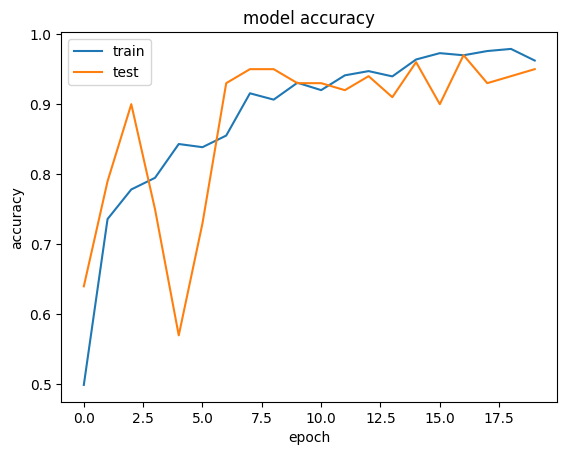

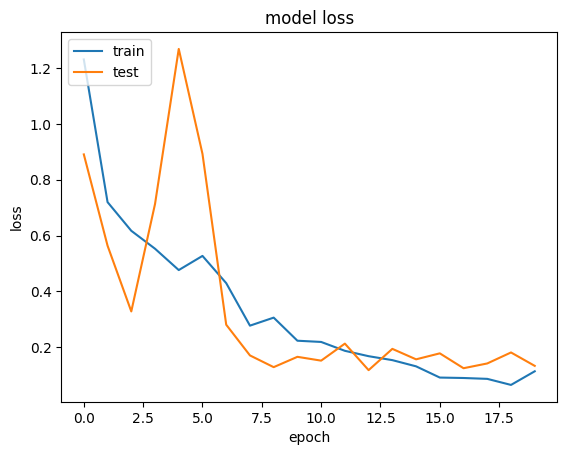

In [20]:
plot_loss_accuracy(history)

8. Mobilenet (retrain all weights)
+ LSTM (128 cells)
+ Dense (128 nodes)
+ Dense (128 nodes)
+ image size 120 by 120
+ 20 images per video
+ random transformations


In [21]:
height = 120
width = 120
num_images = 20
num_epochs = 20
batch_size = 10
print('# height= ', height)
print('# width= ', width)
print('# num_images= ', num_images)
print('# epochs= ', num_epochs)
print('# batch_size= ', batch_size)

train_generator = generator(train_path, train_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width,augment=True)
val_generator = generator(val_path, val_doc, batch_size = batch_size ,num_images = num_images, height=height, width=width)

# height=  120
# width=  120
# num_images=  20
# epochs=  20
# batch_size=  10


In [22]:
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 20, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [23]:
model_name = 'model_init_mobile+LSTM_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-23-d9940f7b7b1e>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-8-f3b148181fa6>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 5s - loss: 0.5734 - categorical_accuracy: 0.8277

<ipython-input-8-f3b148181fa6>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 0.5688 - categorical_accuracy: 0.8296
Epoch 1: saving model to model_init_mobile+LSTM_2_2024-01-2811_34_35.642900/model-00001-0.56877-0.82956-1.05539-0.58000.h5
67/67 [==============================] - 249s 3s/step - loss: 0.5688 - categorical_accuracy: 0.8296 - val_loss: 1.0554 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5875 - categorical_accuracy: 0.8084
Epoch 2: saving model to model_init_mobile+LSTM_2_2024-01-2811_34_35.642900/model-00002-0.58747-0.80845-0.50308-0.82000.h5
67/67 [==============================] - 208s 3s/step - loss: 0.5875 - categorical_accuracy: 0.8084 - val_loss: 0.5031 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4703 - categorical_accuracy: 0.8552
Epoch 3: saving model to model_init_mobile+LSTM_2_2024-01-2811_34_35.642900/model-00003-0.47028-0.85520-0.17977-0

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


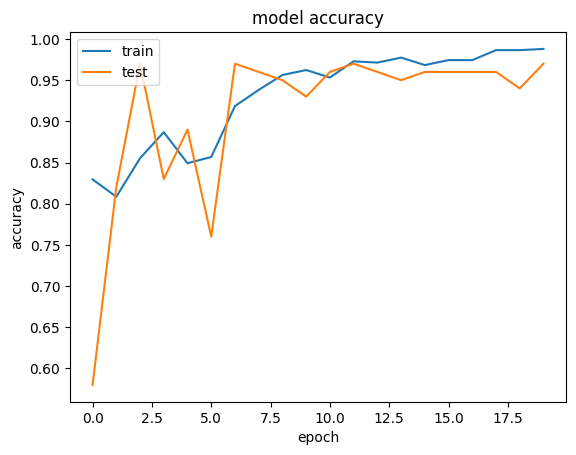

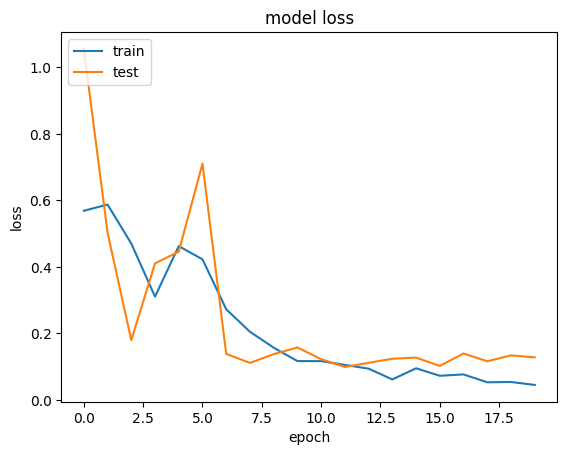

In [24]:
plot_loss_accuracy(history)